In [7]:
import cvxpy as cp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from cvx.covariance.ewma import iterated_ewma, _ewma_mean
from cvx.covariance.combination import from_sigmas
from cvx.covariance.regularization import regularize_covariance, em_regularize_covariance, from_cov_to_precisions, KL_div
from experiments.utils.experiment_utils import *
from experiments.utils.factor_model import *

sns.set()
sns.set(font_scale=1.5)

%load_ext autoreload
%autoreload 2

In [8]:
returns = 100*pd.read_csv("../data/returns_large_universe.csv", index_col=0, parse_dates=True)

# Risk-free rate
FF = pd.read_csv('../data/ff5.csv', index_col=0, parse_dates=True)
rf_rate = pd.DataFrame(FF.loc[:,"RF"])
rf_rate.index = pd.to_datetime(rf_rate.index, format='%Y%m%d')

In [9]:
vola_half_life = 250
corr_half_life = 500

covariances = {}
for predictor in iterated_ewma(returns, vola_half_life, corr_half_life):
    covariances[predictor.time] = predictor.covariance

covariances_yearly = {}
covariances_yearly_non_causal = {}
years = returns.index.year.unique()[4:]

for year in years:
    # get mean of covariances on prior year
    covariances_yearly[year] = pd.DataFrame(np.mean([covariances[date] for date in covariances if date.year == year-1], axis=0), index=returns.columns, columns=returns.columns)
    
    covariances_yearly_non_causal[year] = pd.DataFrame(np.mean([covariances[date] for date in covariances if date.year == year], axis=0), index=returns.columns, columns=returns.columns)


In [10]:
covariance_no_reg = covariances_yearly
covariance_no_reg_non_causal = covariances_yearly_non_causal

In [13]:
times = list(covariances.keys())
time0 = times[0]
Sigma0 = {time0: covariances[time0]}

r = 100
Sigmas_low_rank = dict(regularize_covariance(Sigma0, r=r, low_rank_format=True))
Thetas_low_rank = dict(from_cov_to_precisions(Sigmas_low_rank))

In [40]:


rho = 100
max_iter = 100
eps_abs = 1e-6
eps_rel = 1e-6
alpha = 1.8
max_iter_ccp = 50


### XXX uncomment if history=True
temp = list(ccp_regularize_covariance(Sigma0, Thetas_low_rank, rho=rho, max_iter=max_iter, eps_abs=eps_abs, eps_rel=eps_rel, alpha=alpha, max_iter_ccp=max_iter_ccp, history=True))[0]
time, lr, KL_ccp, history = temp
ccp_lr = {time: lr}
###

### XXX uncomment if history=False
# ccp_lr = dict(ccp_regularize_covariance(Sigma0, Thetas_low_rank, rho=rho,
# max_iter=max_iter, eps_abs=eps_abs, eps_rel=eps_rel, alpha=alpha,
# max_iter_ccp=max_iter_ccp, history=False))
###

G_ccp = ccp_lr[time0].G
e_ccp = ccp_lr[time0].e

Sigma_hat_ccp = np.linalg.inv(np.diag(e_ccp.values)-G_ccp.values@G_ccp.values.T)

  0%|          | 0/50 [00:00<?, ?it/s]/Users/kasper/Documents/Stanford/Research/My papers/w_it_ewma/publicRepo/cov_pred_finance/.venv/lib/python3.9/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/Users/kasper/Documents/Stanford/Research/My papers/w_it_ewma/publicRepo/cov_pred_finance/.venv/lib/python3.9/site-packages/scipy/sparse/linalg/_matfuncs.py:76: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  Ainv = spsolve(A, I)
100%|██████████| 50/50 [08:44<00:00, 10.50s/it]


<Axes: >

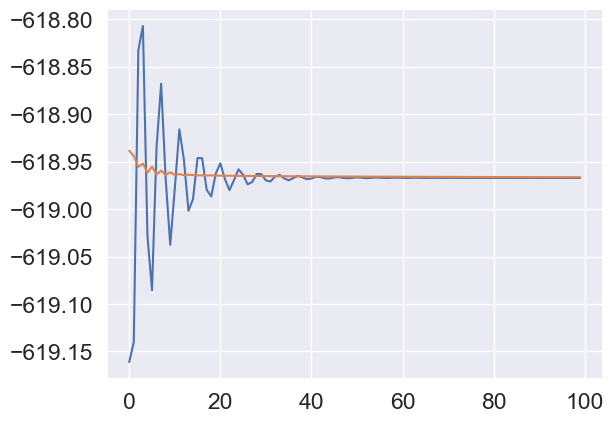

In [41]:
history.obj_vals_ests.plot()
history.obj_vals_true.plot()

In [46]:
em_lr = {}

for time, (cov, KL_em) in em_regularize_covariance(Sigma0, Sigmas_low_rank, history=True):
    em_lr[time] = cov
Sigma_hat_em = em_lr[time0].F@em_lr[time0].F.T + np.diag(em_lr[time0].d.values)


100%|██████████| 500/500 [00:06<00:00, 83.19it/s] 


In [47]:
KL_ccp

array([17.65720621, 14.35887641, 12.31462545, 11.06264937, 10.29302571,
        9.80922921,  9.49444902,  9.28093335,  9.12952585,  9.01758579,
        8.93190606,  8.86453582,  8.81040566,  8.76607192,  8.72908935,
        8.69768906,  8.67058959,  8.64686569,  8.6258476 ,  8.60704292,
        8.59007867,  8.57466188,  8.56055503,  8.54756206,  8.53552073,
        8.52429805,  8.51378687,  8.50390264,  8.49457999,  8.48576912,
        8.47743227,  8.4695402 ,  8.46206936,  8.45499945,  8.44831186,
        8.44198866,  8.43601216,  8.43036476,  8.42502891,  8.41998717,
        8.41522209,  8.41071611,  8.40645144,  8.40240994,  8.39857307,
        8.39492199,  8.39143769,  8.38810129,  8.38489426,  8.38179875])

In [48]:
KL_em

array([11.93620746, 10.07946535,  9.38686819,  9.02610635,  8.80673149,
        8.65880665,  8.55159441,  8.4701015 ,  8.40616846,  8.35481904,
        8.31271427,  8.27746508,  8.24729987,  8.22088442,  8.19721193,
        8.17552878,  8.15528116,  8.13607531,  8.11764682,  8.09983456,
        8.08255554,  8.06577897,  8.04950052,  8.03372092,  8.0184329 ,
        8.00361806,  7.98925206,  7.97531387,  7.96179486,  7.94870435,
        7.93607009,  7.92393344,  7.91234072,  7.90133325,  7.89093863,
        7.88116535,  7.87200153,  7.86341715,  7.85536853,  7.84780359,
        7.84066674,  7.83390276,  7.82745946,  7.82128931,  7.81535033,
        7.80960657,  7.80402843,  7.79859306,  7.7932848 ,  7.78809556,
        7.7830251 ,  7.7780806 ,  7.7732756 ,  7.76862789,  7.76415676,
        7.75987982,  7.7558101 ,  7.75195403,  7.74831066,  7.74487207,
        7.74162474,  7.73855143,  7.73563305,  7.73285028,  7.73018485,
        7.72762025,  7.72514222,  7.72273882,  7.72040042,  7.71

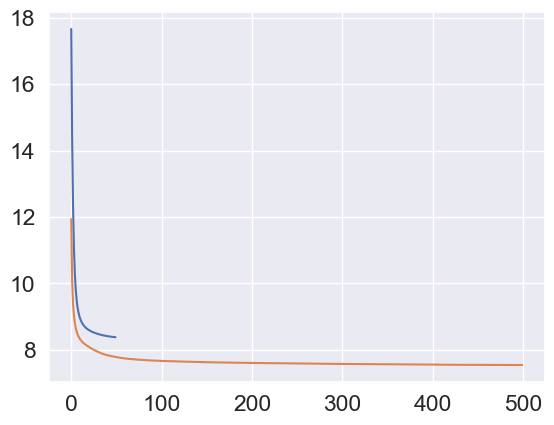

In [49]:
plt.plot(KL_ccp)
plt.plot(KL_em)

In [5]:
def save_cov_to_csv(covs, name):
    """
    param covs: dictionary of time: covariance matrix
    name: name of the csv file

    Saves dataframe of upper triangular covariance matrices to csv file
    with indices being time stamps and columns being the upper triangular part
    """

    covs = {key: cov.values[np.triu_indices_from(cov.values, k=0)] for key, cov in covs.items()}
    covs = pd.DataFrame.from_dict(covs, orient='index')
    covs.index = pd.to_datetime(covs.index, format='%Y%m%d')
    covs.to_csv(f"results/{name}.csv")


def from_upper_triangular_to_full(cov):
    """
    param cov: upper triangular part of covariance matrix
    name: name of the csv file

    returns full covariance matrix
    """

    n = int(np.sqrt(2*len(cov)))
    
    # Reconstruct the full covariance matrix
    full_cov = np.zeros((n, n))
    rows, cols = np.triu_indices(n)
    full_cov[rows, cols] = cov
    full_cov[cols, rows] = cov

    return full_cov


def from_csv_to_cov(name, assets):
    """
    Reads csv file with upper triangular covariance matrices and, converts them
    to full covariance matrices and returns dictionary of time: covariance
    """
    covs = pd.read_csv(f"results/{name}.csv", index_col=0, parse_dates=True)
    covs = {key: pd.DataFrame(from_upper_triangular_to_full(cov), index=assets, columns=assets) for key, cov in covs.iterrows()}
    return covs 

In [6]:
# # covariance_no_reg is the covariance matrix each year 



# covariance_no_reg_non_causal_temp = returns.groupby(returns.index.year).apply(lambda x: x.cov())
# years = covariance_no_reg_non_causal_temp.index.get_level_values(0).unique()
# # make it a dictionary where the key is the year
# covariance_no_reg = {}
# for year in years[1:]:
#     covariance_no_reg[year] = covariance_no_reg_non_causal_temp.loc[year-1]

# covariance_no_reg_non_causal = {}
# for year in years:
#     covariance_no_reg_non_causal[year] = covariance_no_reg_non_causal_temp.loc[year]


### ADMM parameters

In [7]:
rho = 100
max_iter = 100
eps_abs = 1e-6
eps_rel = 1e-6
alpha = 1.8
max_iter_ccp = 5

### ADMM algorithm

##### $r=100$

In [66]:
r = 100
Sigmas_low_rank100 = dict(regularize_covariance(covariance_no_reg, r=r, low_rank_format=True))
Thetas_low_rank100 = dict(from_cov_to_precisions(Sigmas_low_rank100))

In [67]:
sample_ll100 = log_likelihoods_from_sample_cov(covariance_no_reg, covariance_no_reg_non_causal)

sample_noncaus_ll = log_likelihoods_from_sample_cov(covariance_no_reg_non_causal, covariance_no_reg_non_causal)

svd_lr100 = dict(regularize_covariance(covariance_no_reg, 100, low_rank_format=False))

svd_ll100 = log_likelihoods_from_sample_cov(svd_lr100, covariance_no_reg_non_causal)

In [68]:
ccp_lr100 = dict(ccp_regularize_covariance(covariance_no_reg, Thetas_low_rank100, rho=rho,
max_iter=max_iter, eps_abs=eps_abs, eps_rel=eps_rel, alpha=alpha,
max_iter_ccp=max_iter_ccp, history=False))

  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [04:17<00:00, 13.56s/it]


In [69]:
ccp_sigmas100 = {}
for year in years[1:]:
    G = ccp_lr100[year].G
    e = ccp_lr100[year].e

    ccp_sigmas100[year] = pd.DataFrame(np.linalg.inv(np.diag(e) - G@G.T), index=returns.columns, columns=returns.columns)

ccp_ll100 = log_likelihoods_from_sample_cov(ccp_sigmas100, covariance_no_reg_non_causal)

In [70]:
em_lr100 = dict(em_regularize_covariance(covariance_no_reg, Sigmas_low_rank100))

em_sigmas100 = {}
for year in years[1:]:
    F = em_lr100[year].F
    d = em_lr100[year].d

    em_sigmas100[year] = pd.DataFrame(F@F.T + np.diag(d), index=returns.columns, columns=returns.columns)

em_ll100 = log_likelihoods_from_sample_cov(em_sigmas100, covariance_no_reg_non_causal)

<Axes: >

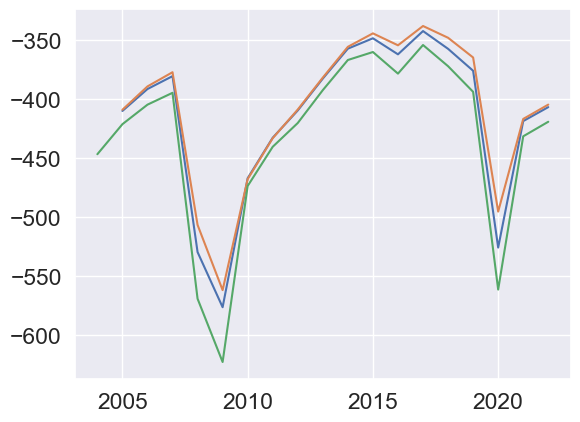

In [71]:
ccp_ll100.plot()
em_ll100.plot()
svd_ll100.plot()
# sample_ll100.plot()

In [72]:
print(ccp_ll100.mean())
print(em_ll100.mean())
print(svd_ll100.mean())

-415.2205161656486
-408.7024636240797
-432.7827028267227


##### $r=75$

In [8]:
r = 75
Sigmas_low_rank75 = dict(regularize_covariance(covariance_no_reg, r=r, low_rank_format=True))
Thetas_low_rank75 = dict(from_cov_to_precisions(Sigmas_low_rank75))

In [9]:
sample_ll75 = log_likelihoods_from_sample_cov(covariance_no_reg, covariance_no_reg_non_causal)

svd_lr75 = dict(regularize_covariance(covariance_no_reg, 75, low_rank_format=False))

svd_ll75 = log_likelihoods_from_sample_cov(svd_lr75, covariance_no_reg_non_causal)

In [10]:
ccp_lr75 = dict(ccp_regularize_covariance(covariance_no_reg, Thetas_low_rank75, rho=rho,
max_iter=max_iter, eps_abs=eps_abs, eps_rel=eps_rel, alpha=alpha,
max_iter_ccp=max_iter_ccp, history=False))

100%|██████████| 19/19 [03:35<00:00, 11.33s/it]


In [11]:
ccp_sigmas75 = {}
for year in years[1:]:
    G = ccp_lr75[year].G
    e = ccp_lr75[year].e

    ccp_sigmas75[year] = pd.DataFrame(np.linalg.inv(np.diag(e) - G@G.T), index=returns.columns, columns=returns.columns)

ccp_ll75 = log_likelihoods_from_sample_cov(ccp_sigmas75, covariance_no_reg_non_causal)

In [12]:
em_lr75 = dict(em_regularize_covariance(covariance_no_reg, Sigmas_low_rank75))

em_sigmas75 = {}
for year in years[1:]:
    F = em_lr75[year].F
    d = em_lr75[year].d

    em_sigmas75[year] = pd.DataFrame(F@F.T + np.diag(d), index=returns.columns, columns=returns.columns)

em_ll75 = log_likelihoods_from_sample_cov(em_sigmas75, covariance_no_reg_non_causal)

<Axes: >

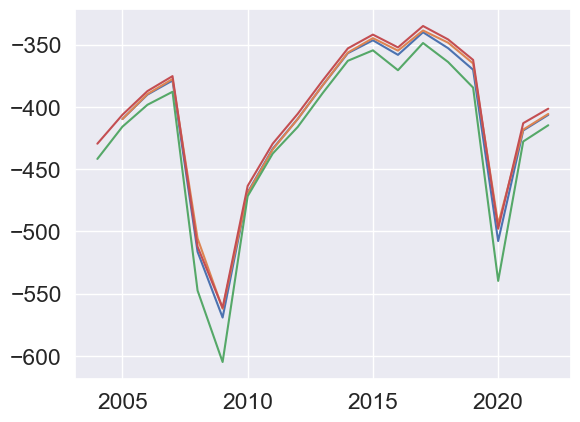

In [13]:
ccp_ll75.plot()
em_ll75.plot()
svd_ll75.plot()
sample_ll75.plot()

In [14]:
print(ccp_ll75.mean())
print(em_ll75.mean())
print(svd_ll75.mean())

-412.06323946662144
-409.30734649938006
-425.1961717559029


##### $r=60$

In [15]:
r = 60
Sigmas_low_rank60 = dict(regularize_covariance(covariance_no_reg, r=r, low_rank_format=True))
Thetas_low_rank60 = dict(from_cov_to_precisions(Sigmas_low_rank60))

In [16]:
sample_ll60 = log_likelihoods_from_sample_cov(covariance_no_reg, covariance_no_reg_non_causal)

svd_lr60 = dict(regularize_covariance(covariance_no_reg, 60, low_rank_format=False))

svd_ll60 = log_likelihoods_from_sample_cov(svd_lr60, covariance_no_reg_non_causal)

In [17]:
ccp_lr60 = dict(ccp_regularize_covariance(covariance_no_reg, Thetas_low_rank60, rho=rho,
max_iter=max_iter, eps_abs=eps_abs, eps_rel=eps_rel, alpha=alpha,
max_iter_ccp=max_iter_ccp, history=False))

100%|██████████| 19/19 [03:23<00:00, 10.69s/it]


In [18]:
ccp_sigmas60 = {}
for year in years[1:]:
    G = ccp_lr60[year].G
    e = ccp_lr60[year].e

    ccp_sigmas60[year] = pd.DataFrame(np.linalg.inv(np.diag(e) - G@G.T), index=returns.columns, columns=returns.columns)

ccp_ll60 = log_likelihoods_from_sample_cov(ccp_sigmas60, covariance_no_reg_non_causal)

In [19]:
em_lr60 = dict(em_regularize_covariance(covariance_no_reg, Sigmas_low_rank60))

em_sigmas60 = {}
for year in years[1:]:
    F = em_lr60[year].F
    d = em_lr60[year].d

    em_sigmas60[year] = pd.DataFrame(F@F.T + np.diag(d), index=returns.columns, columns=returns.columns)

em_ll60 = log_likelihoods_from_sample_cov(em_sigmas60, covariance_no_reg_non_causal)

<Axes: >

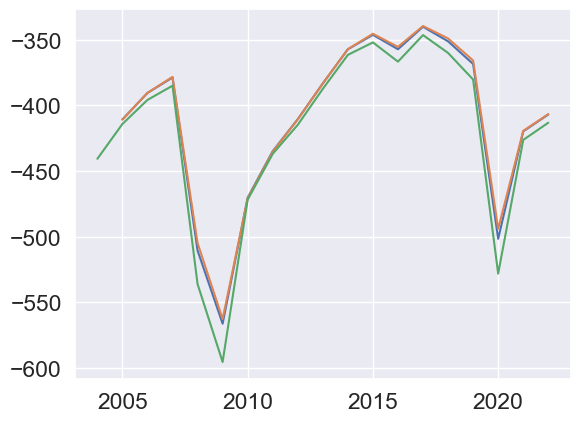

In [20]:
ccp_ll60.plot()
em_ll60.plot()
svd_ll60.plot()
# sample_ll60.plot()

In [21]:
print(ccp_ll60.mean())
print(em_ll60.mean())
print(svd_ll60.mean())

-411.2985055770534
-409.9149010996449
-421.6620650013136


##### $r=50$

In [22]:
r = 50
Sigmas_low_rank50 = dict(regularize_covariance(covariance_no_reg, r=r, low_rank_format=True))
Thetas_low_rank50 = dict(from_cov_to_precisions(Sigmas_low_rank50))

In [23]:
sample_ll50 = log_likelihoods_from_sample_cov(covariance_no_reg, covariance_no_reg_non_causal)

svd_lr50 = dict(regularize_covariance(covariance_no_reg, 50, low_rank_format=False))

svd_ll50 = log_likelihoods_from_sample_cov(svd_lr50, covariance_no_reg_non_causal)

In [24]:
ccp_lr50 = dict(ccp_regularize_covariance(covariance_no_reg, Thetas_low_rank50, rho=rho,
max_iter=max_iter, eps_abs=eps_abs, eps_rel=eps_rel, alpha=alpha,
max_iter_ccp=max_iter_ccp, history=False))

100%|██████████| 19/19 [03:05<00:00,  9.75s/it]


In [25]:
ccp_sigmas50 = {}
for year in years[1:]:
    G = ccp_lr50[year].G
    e = ccp_lr50[year].e

    ccp_sigmas50[year] = pd.DataFrame(np.linalg.inv(np.diag(e) - G@G.T), index=returns.columns, columns=returns.columns)

ccp_ll50 = log_likelihoods_from_sample_cov(ccp_sigmas50, covariance_no_reg_non_causal)

In [26]:
em_lr50 = dict(em_regularize_covariance(covariance_no_reg, Sigmas_low_rank50))

em_sigmas50 = {}
for year in years[1:]:
    F = em_lr50[year].F
    d = em_lr50[year].d

    em_sigmas50[year] = pd.DataFrame(F@F.T + np.diag(d), index=returns.columns, columns=returns.columns)

em_ll50 = log_likelihoods_from_sample_cov(em_sigmas50, covariance_no_reg_non_causal)

<Axes: >

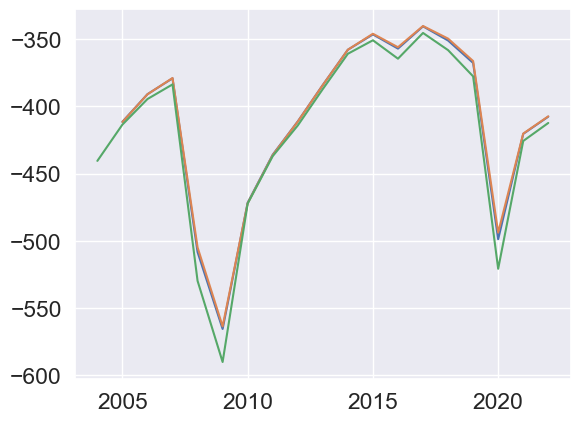

In [27]:
ccp_ll50.plot()
em_ll50.plot()
svd_ll50.plot()

In [28]:
print(ccp_ll50.mean())
print(em_ll50.mean())
print(svd_ll50.mean())

-411.35402299146716
-410.54236422361197
-419.882482094701


##### $r=35$

In [29]:
r = 35
Sigmas_low_rank35 = dict(regularize_covariance(covariance_no_reg, r=r, low_rank_format=True))
Thetas_low_rank35 = dict(from_cov_to_precisions(Sigmas_low_rank35))

In [30]:
sample_ll35 = log_likelihoods_from_sample_cov(covariance_no_reg, covariance_no_reg_non_causal)

svd_lr35 = dict(regularize_covariance(covariance_no_reg, 35, low_rank_format=False))

svd_ll35 = log_likelihoods_from_sample_cov(svd_lr35, covariance_no_reg_non_causal)

In [31]:
ccp_lr35 = dict(ccp_regularize_covariance(covariance_no_reg, Thetas_low_rank35, rho=rho,
max_iter=max_iter, eps_abs=eps_abs, eps_rel=eps_rel, alpha=alpha,
max_iter_ccp=max_iter_ccp, history=False))

  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [02:47<00:00,  8.83s/it]


In [32]:
ccp_sigmas35 = {}
for year in years[1:]:
    G = ccp_lr35[year].G
    e = ccp_lr35[year].e

    ccp_sigmas35[year] = pd.DataFrame(np.linalg.inv(np.diag(e) - G@G.T), index=returns.columns, columns=returns.columns)

ccp_ll35 = log_likelihoods_from_sample_cov(ccp_sigmas35, covariance_no_reg_non_causal)

In [33]:
em_lr35 = dict(em_regularize_covariance(covariance_no_reg, Sigmas_low_rank35))

em_sigmas35 = {}
for year in years[1:]:
    F = em_lr35[year].F
    d = em_lr35[year].d

    em_sigmas35[year] = pd.DataFrame(F@F.T + np.diag(d), index=returns.columns, columns=returns.columns)

em_ll35 = log_likelihoods_from_sample_cov(em_sigmas35, covariance_no_reg_non_causal)

<Axes: >

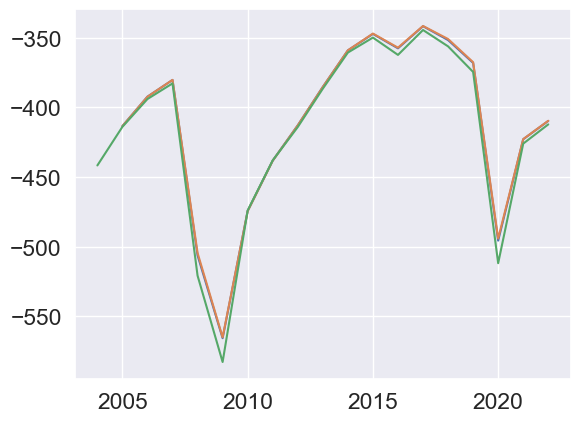

In [34]:
ccp_ll35.plot()
em_ll35.plot()
svd_ll35.plot()

In [35]:
print(ccp_ll35.mean())
print(em_ll35.mean())
print(svd_ll35.mean())

-412.2892192613979
-411.9662700255451
-418.18838431795956


##### $r=20$

In [36]:
r = 20
Sigmas_low_rank20 = dict(regularize_covariance(covariance_no_reg, r=r, low_rank_format=True))
Thetas_low_rank20 = dict(from_cov_to_precisions(Sigmas_low_rank20))

In [37]:
sample_ll20 = log_likelihoods_from_sample_cov(covariance_no_reg, covariance_no_reg_non_causal)

svd_lr20 = dict(regularize_covariance(covariance_no_reg, 20, low_rank_format=False))

svd_ll20 = log_likelihoods_from_sample_cov(svd_lr20, covariance_no_reg_non_causal)

In [38]:
ccp_lr20 = dict(ccp_regularize_covariance(covariance_no_reg, Thetas_low_rank20, rho=rho,
max_iter=max_iter, eps_abs=eps_abs, eps_rel=eps_rel, alpha=alpha,
max_iter_ccp=max_iter_ccp, history=False))

  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [02:26<00:00,  7.71s/it]


In [39]:
ccp_sigmas20 = {}
for year in years[1:]:
    G = ccp_lr20[year].G
    e = ccp_lr20[year].e

    ccp_sigmas20[year] = pd.DataFrame(np.linalg.inv(np.diag(e) - G@G.T), index=returns.columns, columns=returns.columns)

ccp_ll20 = log_likelihoods_from_sample_cov(ccp_sigmas20, covariance_no_reg_non_causal)

In [40]:
em_lr20 = dict(em_regularize_covariance(covariance_no_reg, Sigmas_low_rank20))

em_sigmas20 = {}
for year in years[1:]:
    F = em_lr20[year].F
    d = em_lr20[year].d

    em_sigmas20[year] = pd.DataFrame(F@F.T + np.diag(d), index=returns.columns, columns=returns.columns)

em_ll20 = log_likelihoods_from_sample_cov(em_sigmas20, covariance_no_reg_non_causal)

<Axes: >

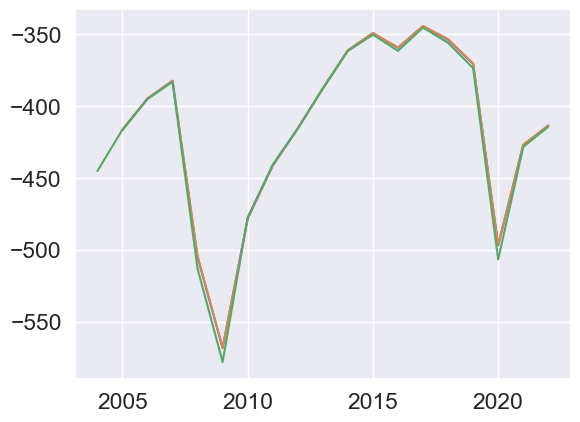

In [41]:
ccp_ll20.plot()
em_ll20.plot()
svd_ll20.plot()

In [42]:
print(ccp_ll20.mean())
print(em_ll20.mean())
print(svd_ll20.mean())

-415.0324767795917
-414.85021107277214
-418.6795576603325


##### $r=10$

In [43]:
r = 10
Sigmas_low_rank10 = dict(regularize_covariance(covariance_no_reg, r=r, low_rank_format=True))
Thetas_low_rank10 = dict(from_cov_to_precisions(Sigmas_low_rank10))

In [44]:
sample_ll10 = log_likelihoods_from_sample_cov(covariance_no_reg, covariance_no_reg_non_causal)

svd_lr10 = dict(regularize_covariance(covariance_no_reg, 10, low_rank_format=False))

svd_ll10 = log_likelihoods_from_sample_cov(svd_lr10, covariance_no_reg_non_causal)

In [45]:
ccp_lr10 = dict(ccp_regularize_covariance(covariance_no_reg, Thetas_low_rank10, rho=rho,
max_iter=max_iter, eps_abs=eps_abs, eps_rel=eps_rel, alpha=alpha,
max_iter_ccp=max_iter_ccp, history=False))

100%|██████████| 19/19 [02:11<00:00,  6.93s/it]


In [46]:
ccp_sigmas10 = {}
for year in years[1:]:
    G = ccp_lr10[year].G
    e = ccp_lr10[year].e

    ccp_sigmas10[year] = pd.DataFrame(np.linalg.inv(np.diag(e) - G@G.T), index=returns.columns, columns=returns.columns)

ccp_ll10 = log_likelihoods_from_sample_cov(ccp_sigmas10, covariance_no_reg_non_causal)

In [47]:
em_lr10 = dict(em_regularize_covariance(covariance_no_reg, Sigmas_low_rank10))

em_sigmas10 = {}
for year in years[1:]:
    F = em_lr10[year].F
    d = em_lr10[year].d

    em_sigmas10[year] = pd.DataFrame(F@F.T + np.diag(d), index=returns.columns, columns=returns.columns)

em_ll10 = log_likelihoods_from_sample_cov(em_sigmas10, covariance_no_reg_non_causal)

<Axes: >

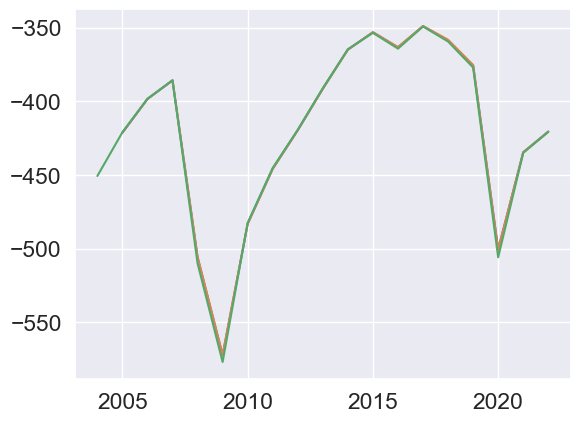

In [48]:
ccp_ll10.plot()
em_ll10.plot()
svd_ll10.plot()

In [49]:
print(ccp_ll10.mean())
print(em_ll10.mean())
print(svd_ll10.mean())

-419.1491448894299
-419.11401468608335
-421.6764249514193


##### $r=5$ 

In [50]:
r = 5
Sigmas_low_rank5 = dict(regularize_covariance(covariance_no_reg, r=r, low_rank_format=True))
Thetas_low_rank5 = dict(from_cov_to_precisions(Sigmas_low_rank5))

In [51]:
sample_ll5 = log_likelihoods_from_sample_cov(covariance_no_reg, covariance_no_reg_non_causal)

svd_lr5 = dict(regularize_covariance(covariance_no_reg, 5, low_rank_format=False))

svd_ll5 = log_likelihoods_from_sample_cov(svd_lr5, covariance_no_reg_non_causal)

In [52]:
ccp_lr5 = dict(ccp_regularize_covariance(covariance_no_reg, Thetas_low_rank5, rho=rho,
max_iter=max_iter, eps_abs=eps_abs, eps_rel=eps_rel, alpha=alpha,
max_iter_ccp=max_iter_ccp, history=False))

  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [02:06<00:00,  6.68s/it]


In [53]:
ccp_sigmas5 = {}
for year in years[1:]:
    G = ccp_lr5[year].G
    e = ccp_lr5[year].e

    ccp_sigmas5[year] = pd.DataFrame(np.linalg.inv(np.diag(e) - G@G.T), index=returns.columns, columns=returns.columns)

ccp_ll5 = log_likelihoods_from_sample_cov(ccp_sigmas5, covariance_no_reg_non_causal)

In [54]:
em_lr5 = dict(em_regularize_covariance(covariance_no_reg, Sigmas_low_rank5))

em_sigmas5 = {}
for year in years[1:]:
    F = em_lr5[year].F
    d = em_lr5[year].d

    em_sigmas5[year] = pd.DataFrame(F@F.T + np.diag(d), index=returns.columns, columns=returns.columns)

em_ll5 = log_likelihoods_from_sample_cov(em_sigmas5, covariance_no_reg_non_causal)

<Axes: >

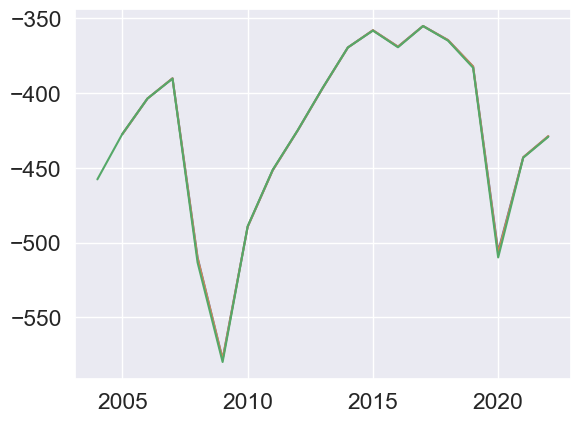

In [55]:
ccp_ll5.plot()
em_ll5.plot()
svd_ll5.plot()

In [56]:
print(ccp_ll5.mean())
print(em_ll5.mean())
print(svd_ll5.mean())

-424.8702177675547
-424.9479684205042
-427.1656694479086


##### $r=2$

In [57]:
r = 2
Sigmas_low_rank2 = dict(regularize_covariance(covariance_no_reg, r=r, low_rank_format=True))
Thetas_low_rank2 = dict(from_cov_to_precisions(Sigmas_low_rank2))

In [58]:
sample_ll2 = log_likelihoods_from_sample_cov(covariance_no_reg, covariance_no_reg_non_causal)

svd_lr2 = dict(regularize_covariance(covariance_no_reg, 2, low_rank_format=False))

svd_ll2 = log_likelihoods_from_sample_cov(svd_lr2, covariance_no_reg_non_causal)

In [59]:
ccp_lr2 = dict(ccp_regularize_covariance(covariance_no_reg, Thetas_low_rank2, rho=rho,
max_iter=max_iter, eps_abs=eps_abs, eps_rel=eps_rel, alpha=alpha,
max_iter_ccp=max_iter_ccp, history=False))

100%|██████████| 19/19 [02:07<00:00,  6.72s/it]


In [60]:
ccp_sigmas2 = {}
for year in years[1:]:
    G = ccp_lr2[year].G
    e = ccp_lr2[year].e

    ccp_sigmas2[year] = pd.DataFrame(np.linalg.inv(np.diag(e) - G@G.T), index=returns.columns, columns=returns.columns)

ccp_ll2 = log_likelihoods_from_sample_cov(ccp_sigmas2, covariance_no_reg_non_causal)

In [61]:
em_lr2 = dict(em_regularize_covariance(covariance_no_reg, Sigmas_low_rank2))

em_sigmas2 = {}
for year in years[1:]:
    F = em_lr2[year].F
    d = em_lr2[year].d

    em_sigmas2[year] = pd.DataFrame(F@F.T + np.diag(d), index=returns.columns, columns=returns.columns)

em_ll2 = log_likelihoods_from_sample_cov(em_sigmas2, covariance_no_reg_non_causal)

<Axes: >

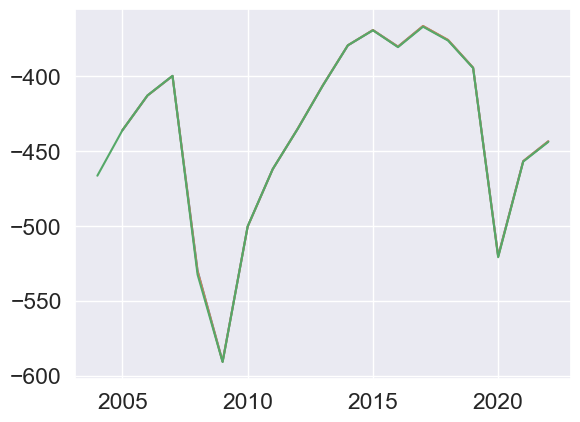

In [62]:
ccp_ll2.plot()
em_ll2.plot()
svd_ll2.plot()

In [63]:
print(ccp_ll2.mean())
print(em_ll2.mean())
print(svd_ll2.mean())

-436.69531183356185
-436.709373997317
-438.5522390147112


In [73]:
ll_ccp_means = [ccp_ll2.mean(), ccp_ll5.mean(), ccp_ll10.mean(), ccp_ll20.mean(), ccp_ll35.mean(), ccp_ll50.mean(), ccp_ll60.mean(), ccp_ll75.mean(), ccp_ll100.mean()]
ll_em_means = [em_ll2.mean(), em_ll5.mean(), em_ll10.mean(), em_ll20.mean(), em_ll35.mean(), em_ll50.mean(), em_ll60.mean(), em_ll75.mean(), em_ll100.mean()]
ll_svd_means = [svd_ll2.mean(), svd_ll5.mean(), svd_ll10.mean(), svd_ll20.mean(), svd_ll35.mean(), svd_ll50.mean(), svd_ll60.mean(), svd_ll75.mean(), svd_ll100.mean()]

rs = [2, 5, 10, 20, 35, 50, 60, 75, 100]

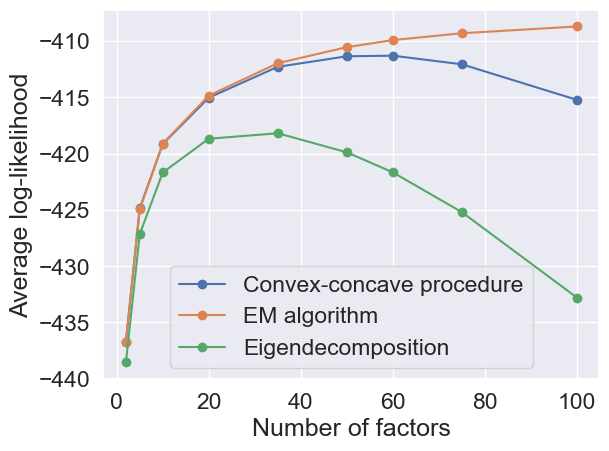

In [75]:
plt.plot(rs, ll_ccp_means, label="Convex-concave procedure", marker='o')
plt.plot(rs, ll_em_means, label="EM algorithm", marker='o')
plt.plot(rs, ll_svd_means, label="Eigendecomposition", marker='o')
plt.xlabel("Number of factors")
plt.ylabel("Average log-likelihood")
plt.legend();